# Transfer Learning with PyTorch

During this notebook we'll create a custom dataset using the [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/).

Then we'll create 3 models: 2 for object detection and 1 for instance segmentation.

Finally we'll train the instance segmentation model using the custom dataset.

## Dataset

In [92]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import progressbar
from urllib.request import urlretrieve
from zipfile import ZipFile
import matplotlib.pyplot as plt
from random import randint
import cv2

import torchvision.transforms as transforms

In [44]:
FOLDER_NAME = 'dataset'

### Download the dataset

In [45]:
ZIP_URL = 'https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip'
ZIP_NAME = f"{FOLDER_NAME}/{ZIP_URL.split('/')[-1]}"
PENN_FUDAN_FOLDER = f"{FOLDER_NAME}/{ZIP_URL.split('/')[-1].split('.')[0]}"

In [46]:
def show_progress(block_num, block_size, total_size):
    global pbar
    if pbar is None:
        pbar = progressbar.ProgressBar(maxval=total_size)
        pbar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(downloaded)
    else:
        pbar.finish()
        pbar = None

In [47]:
pbar = None

if not os.path.exists(PENN_FUDAN_FOLDER):
    print("Downloading training and validation data...")
    urlretrieve(ZIP_URL, ZIP_NAME, show_progress)
    print("Downloaded succesfully!")

    print(f"Extracting the content of both zips on the {FOLDER_NAME} folder...")
    zip_ref = ZipFile(file=ZIP_NAME, mode="r")
    zip_ref.extractall(FOLDER_NAME)
    zip_ref.close()
    print("All files have been extracted succesfully!")

    os.remove(ZIP_NAME)

Our dataset looks like:
```
pytorch-notes
│
dataset      
│   │   ...
|   └───PennFudanPed
│       │ Annotation                # Annotations for each image
│       │ PedMasks                  # Masks for each image
│       │                           # labels:
│       │                           # -  0 to background
│       │                           # -  1 for 1st pedestrian, 2 for 2nd, ...
│       │ PNGImages                 # All the images in PNG
│       │ added-object-list.txt     # Img name & object index
│       │ readme.txt        
```

Compatible with PASCAL Annotation Version (for the bounding boxes):

`Bounding box for object 1 "PASpersonWalking" (Xmin, Ymin) - (Xmax, Ymax) : (160, 182) - (302, 431)`

Image size (X x Y x C) : 559 x 536 x 3

### Define the dataset

`__getitem__` should return:
- image: a PIL Image of size (H, W)
- target: a dict with the following fields:
    - `boxes` `(FloatTensor[N, 4])`: Coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]`.
    - `labels` `(Int64Tensor[N])`: Label for each bounding box as specified on the tree.
    - `image_id` `(Int64Tensor[1])`: Image identifier.
    - `area` `(Tensor[N])`: Area of the bounding box.
    - `iscrowd (UInt8Tensor[N])`: Instances with iscrowd=True will be ignored during evaluation.
    - `masks` `(UInt8Tensor[N, H, W])`: The segmentation masks for each one of the objects.
    - `keypoints` `(FloatTensor[N, K, 3])`: For each one of the N objects, it contains the K keypoints in `[x, y, visibility]` format. visibility=0 means the keypoint is not visible.

In [48]:
class PennFudanPedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = list(sorted(os.listdir(os.path.join(root_dir, 'pngimages'))))
        self.masks = list(sorted(os.listdir(os.path.join(root_dir, 'PedMasks'))))
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, 'PNGImages', self.images[idx])
        mask_path = os.path.join(self.root_dir, 'PedMasks', self.masks[idx])
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path) # be careful: don't change mask's color

        mask = np.array(mask)
        # instances are encoded as different colors:
        obj_ids = np.unique(mask)
        # first id is background, so remove it
        obj_ids = obj_ids[1:] # [0, 1, 2] -> [1, 2]

        # split the color-encoded mask into a set of binary (True/False) masks
        # The last 2 None allows us to interpret obj_ids as a matrix
        masks = mask == obj_ids[:, None, None] 

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        bboxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[1])
            bboxes.append([xmin, ymin, xmax, ymax])
        
        # convert everything into a torch.Tensor
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        # (ymax - ymin) * (xmax - xmin) = y * x
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = bboxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transform:
            image, target = self.transform(image, target)
        
        return image, target

### Data augmentation with torchvision

In [42]:
def get_transform(train):
    transforms_list = []
    transforms_list.append(transforms.ToTensor())
    if train:
        transforms_list.append(transforms.RandomHorizontalFlip(0.5))
    return transforms.Compose(transforms_list)

### Take a look at the dataset

In [51]:
dataset = PennFudanPedDataset(PENN_FUDAN_FOLDER, transform=None)

In [95]:
def plot_image_and_mask(image, masks, show=False):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, len(masks)+1, 1)
    plt.axis('off')
    plt.imshow(image)

    for i in range(len(masks)):
        plt.subplot(1, len(masks)+1, i+2)
        plt.axis('off')
        plt.imshow(transforms.ToPILImage()(masks[i]), cmap='gray')

    if show: plt.show()

def multiple_images_and_masks(dataset, num=5):
    for i in range(num):
        image, target = dataset[randint(0, len(dataset)-1)]
        masks = target["masks"]

        plot_image_and_mask(image, masks)
    
    plt.show()

def visualize_bbox(img, bboxes, color=(255, 0, 0), thickness=5):
    """Visualizes a single bounding box on the image"""
    img = np.array(img)
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = map(int, bbox)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)
    return img

def plot_image_bbox(dataset):
    image, target = dataset[randint(0, len(dataset)-1)]
    bboxes = target["boxes"]

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(image)

    image_with_bbox = visualize_bbox(image, bboxes)
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(image_with_bbox)

    plt.show()

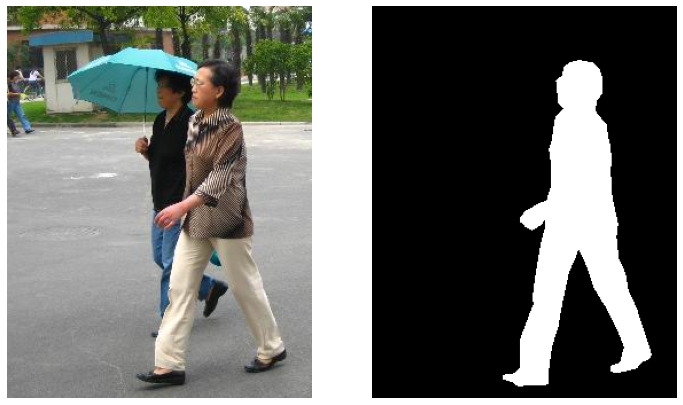

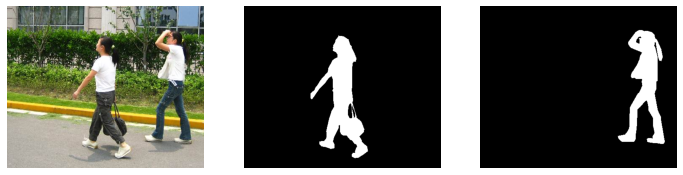

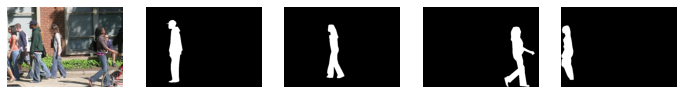

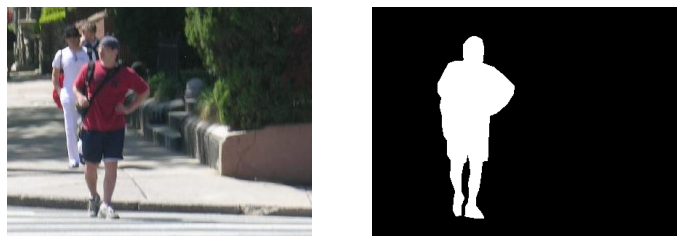

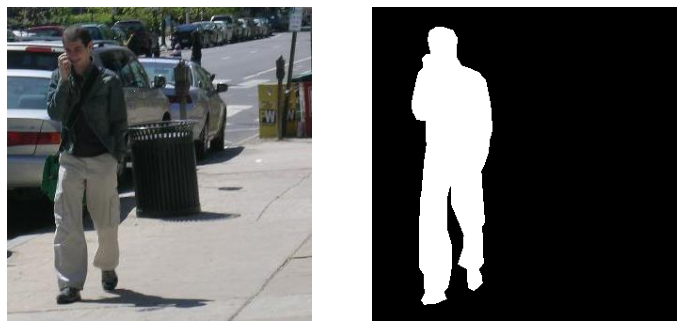

In [91]:
multiple_images_and_masks(dataset)

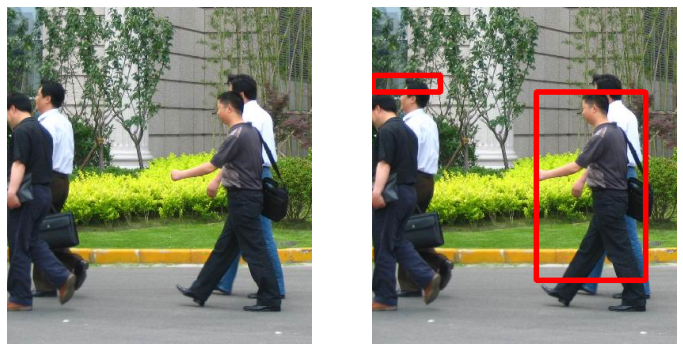

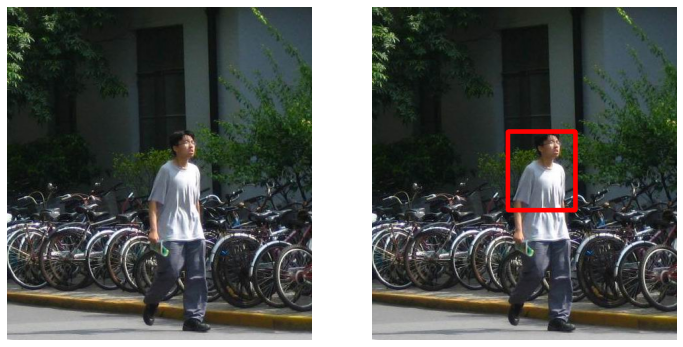

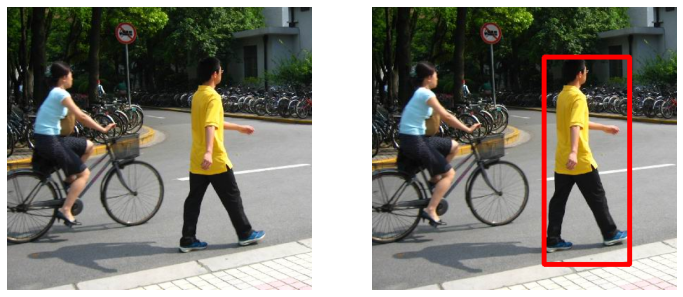

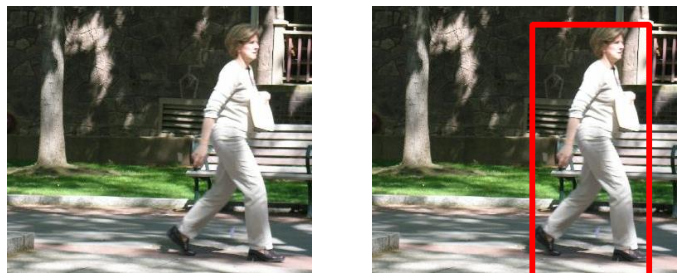

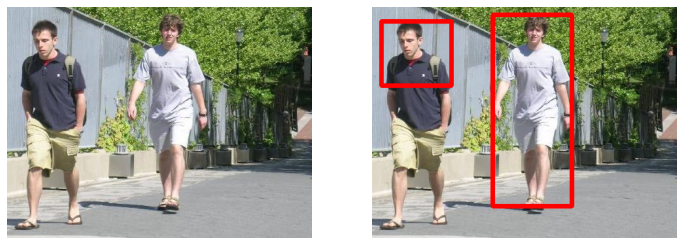

In [98]:
for i in range(5):
    plot_image_bbox(dataset)

## Models

In [34]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, maskrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import mobilenet_v2

### Different models: Uncomment one and comment the rest

### 1. Object Detection with FasterRCNN & FPN

FasterRCNN with FPN model summary `print(fasterrcnn_resnet50_fpn)`:
```
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)
          )
        )
        ...
    (fpn): FeaturePyramidNetwork(
      (inner_blocks): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (layer_blocks): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (extra_blocks): LastLevelMaxPool()
    )
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
      (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (roi_heads): RoIHeads(
    (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
    (box_head): TwoMLPHead(
      (fc6): Linear(in_features=12544, out_features=1024, bias=True)
      (fc7): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (box_predictor): FastRCNNPredictor(
      (cls_score): Linear(in_features=1024, out_features=91, bias=True)
      (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
    )
  )
)
```

See that, here, the roi_heads is the classifier. So it's what we'll want to substitute to finetune our model.

FastRCNNPredictor:
```
class FastRCNNPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas
```

We can substitute the bboxes predictor of the previous model with this new one. 

In [38]:
def get_detection_model_frp(num_classes=2):
    """Object Detection model based on the FasterRCNN, a ResNet50 & a FPN
    
    Args:
        - num_classes: number of output classes of that our model has to detect.
                       Example: num_classes=2 <- 1 for person & 1 for background
    """
    # load a model pre-trained on COCO
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    ### REPLACE THE CLASSIFIER ###
    # get the number of input features & substitute the predictor with a new one
    # with a different number of features
    in_features = model.roi_heads.box_predictor.cls_score.in_features # 1024
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### 2. Object detection with FasterRCNN & MobileNetV2 as the backbone

MobileNetV2 summary:
```
MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      ...
    )
    ...
    (18): ConvBNActivation(
      (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
  )
)
```

In [39]:
def get_detection_model_fm():
    """Object detection model based on MobileNetV2 & the FasterRCNN"""
    # load the pre-trained MobileNetV2 and remove the classifier
    backbone = mobilenet_v2(pretrained=True).features
    # FasterRCNN needs the num. of O/T channels, for this model is 1280:
    backbone.out_channels = 1280

    # Anchors with 5 different sizes & 3 different aspect ratios
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    # feature maps we'll use to perform the region of interest cropping
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone,
        num_classes=2,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

### 3. Instance Segmentation with Mask R-CNN

Mask R-CNN with ResNet50 & FPN:
```
MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    ...
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
      (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (roi_heads): RoIHeads(
    (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
    (box_head): TwoMLPHead(
      (fc6): Linear(in_features=12544, out_features=1024, bias=True)
      (fc7): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (box_predictor): FastRCNNPredictor(
      (cls_score): Linear(in_features=1024, out_features=91, bias=True)
      (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
    )
    (mask_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(14, 14), sampling_ratio=2)
    (mask_head): MaskRCNNHeads(
      (mask_fcn1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU(inplace=True)
      (mask_fcn2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU(inplace=True)
      (mask_fcn3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU(inplace=True)
      (mask_fcn4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu4): ReLU(inplace=True)
    )
    (mask_predictor): MaskRCNNPredictor(
      (conv5_mask): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
      (relu): ReLU(inplace=True)
      (mask_fcn_logits): Conv2d(256, 91, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

```

In [40]:
def get_model_instance_segmentation(num_classes):
    # Mask R-CNN pre-trained on COCO
    model = maskrcnn_resnet50_fpn(pretrained=True)
    
    # num. of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained box predictor
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels # 256
    hidden_layer = 256
    # replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_channels=in_features_mask,
        dim_reduced=hidden_layer,
        num_classes=num_classes
    )

    return model